### 矢量数据与栅格数据相互转换

#### 1. 栅格数据矢量化

In [1]:
import rasterio as rio
import matplotlib.pyplot as plt

In [2]:
path_mndwi_thre = 'data/data-section-6/s2_chenggong_mndwi_thre015.tif'   # 栅格数据


In [22]:
with rio.open(path_mndwi_thre) as src:
    arr = src.read(1)
    transform = src.transform
    crs = src.crs
print(crs)
# print(transform)
# print(arr.shape)

# rsimg_rio = rio.open(path_mndwi_thre)
# arr = rsimg_rio.read(1)
# transform = rsimg_rio.transform
# crs = rsimg_rio.crs
# crs


EPSG:4326


In [23]:
import numpy as np
print(np.unique(arr))
arr[arr<-100000]=np.nan
print(np.unique(arr))

[-3.4028235e+38  0.0000000e+00  1.0000000e+00]
[ 0.  1. nan]


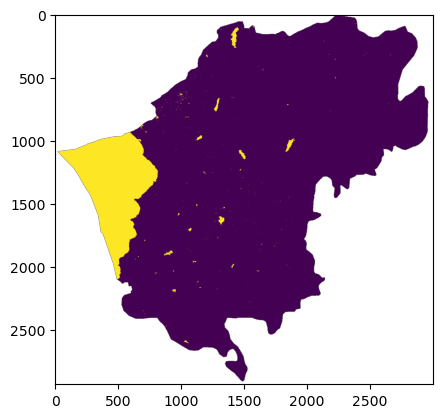

In [24]:
plt.imshow(arr)

In [6]:
from rasterio import features
from shapely import Polygon

## 将二值图像转为几何图形顶点坐标
geos_values = features.shapes(arr, transform=transform) ## generator
print(next(geos_values))
## 分别获取几何面和几何面对应的像元值
geos, values = [], []
for geo, value in geos_values:
    geos.append(geo['coordinates'])
    values.append(value)

geos = [Polygon(geo[0]) for geo in geos]  ## 由序列坐标转为几何面


({'type': 'Polygon', 'coordinates': [[(102.92703313918389, 24.990082846795495), (102.92703313918389, 24.989982261049068), (102.92934647117191, 24.989982261049068), (102.92934647117191, 24.990082846795495), (102.92703313918389, 24.990082846795495)]]}, 1.0)


<Axes: >

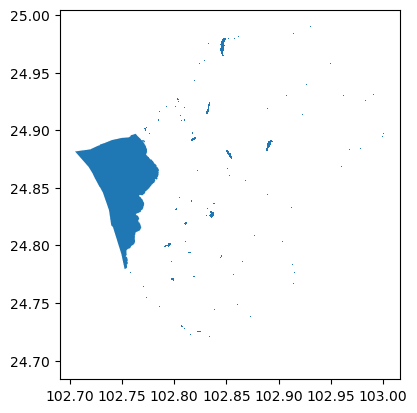

In [ ]:
import geopandas as gpd
## 将获取的几何面和像元值创建为geopandas.dataframe数据类型。
poly_gdf = gpd.GeoDataFrame({'value':values, 'geometry':geos}, crs=crs)
poly_gdf = poly_gdf[poly_gdf.value==1]
poly_gdf.plot()
# poly_gdf.to_file('data/data-section-6/chenggong_mndwi_thre_vec.gpkg', driver='GPKG')



#### 2. 矢量数据栅格化

In [8]:
import geopandas as gpd
import rasterio as rio
from rasterio import features     
import matplotlib.pyplot as plt
import numpy as np


In [9]:
path_vec = 'data/data-section-6/chenggong_mndwi_thre_vec.gpkg'


   value                                           geometry
0    1.0  POLYGON ((102.92703 24.99008, 102.92703 24.989...
1    1.0  POLYGON ((102.92683 24.98998, 102.92683 24.989...
2    1.0  POLYGON ((102.93015 24.98998, 102.93015 24.989...
3    1.0  POLYGON ((102.92663 24.98978, 102.92663 24.989...
4    1.0  POLYGON ((102.93126 24.98978, 102.93126 24.989...


<Axes: >

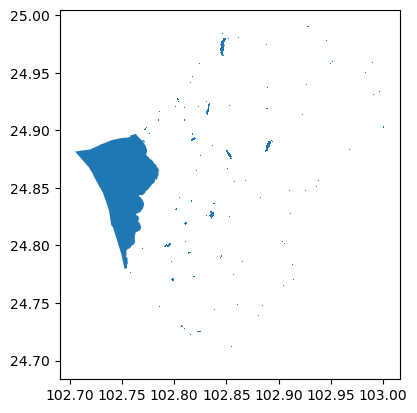

In [10]:
vec_gpd = gpd.read_file(path_vec)
print(vec_gpd.head())
vec_gpd.plot()


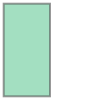

In [11]:
## 遍历几何
geos = []
for geo in vec_gpd.geometry:
    geos.append(geo)
geos[1]

In [12]:
path_base_raster = 'data/data-section-6/s2_chenggong_mndwi_thre015.tif'  ## (1)能覆盖矢量数据范围,(2)相同坐标系
raster = rio.open(path_base_raster)
print(raster.bounds)
print(raster.res)
raster.meta


BoundingBox(left=102.70324341425528, bottom=24.695869538495074, right=103.00458005060858, top=24.99108870425977)
(0.00010057965165330377, 0.00010058574642749426)


{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 2996,
 'height': 2935,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'),
 'transform': Affine(0.00010057965165330377, 0.0, 102.70324341425528,
        0.0, -0.00010058574642749426, 24.99108870425977)}

In [13]:
### (1) 仅根据矢量数据几何信息进行栅格化
rasterized = features.rasterize(shapes=geos,
                                out_shape = raster.shape,    ## 此处.shape获取二维形状
                                fill = 0,  ## 栅格化填充值
                                transform = raster.transform,
                                default_value = 1  # 几何体填充值
                                )


In [14]:
np.unique(rasterized)


array([0, 1])

可视化栅格化结果

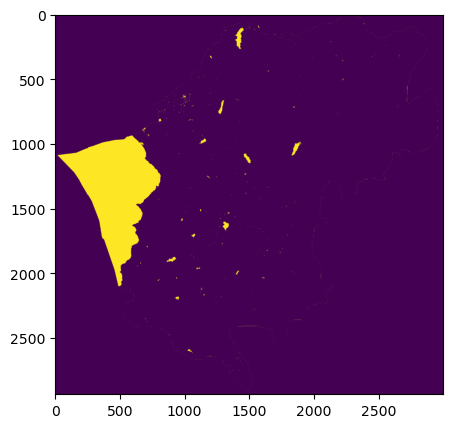

In [15]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.imshow(rasterized)


In [16]:
vec_gpd['id'] = vec_gpd.index
vec_gpd

,value,geometry,id
0,1.0,"POLYGON ((102.92703 24.99008, 102.92703 24.989...",0
1,1.0,"POLYGON ((102.92683 24.98998, 102.92683 24.989...",1
2,1.0,"POLYGON ((102.93015 24.98998, 102.93015 24.989...",2
3,1.0,"POLYGON ((102.92663 24.98978, 102.92663 24.989...",3
4,1.0,"POLYGON ((102.93126 24.98978, 102.93126 24.989...",4
...,...,...,...
1702,1.0,"POLYGON ((102.85441 24.7008, 102.85441 24.7006...",1702
1703,1.0,"POLYGON ((102.85431 24.69989, 102.85431 24.699...",1703
1704,1.0,"POLYGON ((102.85411 24.69909, 102.85411 24.698...",1704
1705,1.0,"POLYGON ((102.8518 24.69859, 102.8518 24.69838...",1705


In [17]:
### 矢量数据几何信息结合属性值进行栅格化 （自行学习）
geos_values = zip(list(vec_gpd['geometry']), list(vec_gpd['id']))
geos_values = list(geos_values)
# Rasterize vector using the shape and transform of the raster
rasterized_2 = features.rasterize(shapes=geos_values,
                                out_shape = raster.shape,
                                transform = raster.transform,
                                fill = 0,   # background value
                                )


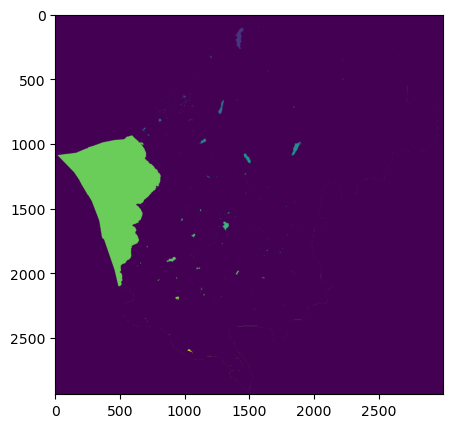

In [18]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
ax.imshow(rasterized_2)


写出栅格化数据

In [19]:
path_raster_save = 'data/data-section-6/chenggong_mndwi_thre_vec_raster.tif'
with rio.open(path_raster_save, 'w', driver=raster.driver, 
                   height=raster.height,
                   width=raster.width,
                   count=1,
                   dtype=np.int16,
                   crs=raster.crs,
                   transform=raster.transform) as dst:
  dst.write(rasterized, 1)    ## the number 1 is the number of bands.
